In [1]:
import pandas as pd
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pyplot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, Average, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.applications.resnet50 as resnet50
import tensorflow.keras.applications.inception_resnet_v2 as inception_resnet_v2
import tensorflow.keras.applications.resnet_v2 as resnet_v2
import tensorflow.keras.applications.mobilenet_v2 as mobilenet_v2
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2021-11-20 12:22:56.090080: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-20 12:23:00.951512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:37:00.0, compute capability: 7.0


# Import Image

In [3]:
NUM_CLASSES=12
BATCH_SIZE=16
EPOCHS=30
IMG_HEIGHT=299
IMG_WIDTH=299
NUM_HIDDEN_NEURONS=128
DROPOUT_RATE=0.4
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 3)

In [4]:
base_dir = "./plant-seedlings-classification"
train_dir = f"{base_dir}/train/"
test_dir = f"{base_dir}/test/"

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    color_mode ="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    directory=base_dir,
    classes=['test'],
    batch_size=1,
    color_mode="rgb",
    shuffle=False,
    class_mode="categorical"
)

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Found 794 images belonging to 1 classes.


# Define base learning algorithms for the stacked model

In [6]:
def create_compile_resnet50(model_name=None):
    
    model = Sequential(name=model_name)
    model.add(resnet50.ResNet50(include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(12, activation='softmax'))
    
    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model
    
def create_compile_inception_resnet_v2(model_name=None):
    model = Sequential(name=model_name)
    # add base pre-trained model
    model.add(inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(12, activation='softmax'))
    
    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

def create_compile_resnet101_v2(model_name=None):
    model = Sequential(name=model_name)
    # add base pre-trained model
    model.add(resnet_v2.ResNet101V2(include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(12, activation='softmax'))
    
    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return model
    

In [7]:
def train(model, num_epochs):

    filepath='weights/'+model.name+'.hdf5'
    
    checkpoint=ModelCheckpoint(
                filepath, 
                monitor='loss', 
                verbose=0, save_weights_only=True,
                save_best_only=True, 
                mode='max')
    with tf.device("/device:GPU:0"):
        history=model.fit(
              train_generator,
              epochs = num_epochs,
              validation_data=validation_generator,
              callbacks=[checkpoint]
        )
    weight_files = glob.glob(os.path.join(os.getcwd(), 'weights/*'))
    if len(weight_files) > 0:
        weight_file = max(weight_files, key=os.path.getctime) # most recent file
    else:
        weight_file = filepath
    return history, weight_file

In [8]:
# ResNet
model_1_name="resnet"
model_1=create_compile_resnet50(model_1_name)
model_1_hist, model_1_best_weights_file=train(model_1, EPOCHS)

2021-11-20 12:23:43.544989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:37:00.0, compute capability: 7.0
2021-11-20 12:23:50.154974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-11-20 12:23:56.829885: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


238/238 [==============================] - 188s 743ms/step - loss: 0.8915 - accuracy: 0.7136 - val_loss: 4.2010 - val_accuracy: 0.0549
Epoch 2/30
238/238 [==============================] - 115s 483ms/step - loss: 0.3780 - accuracy: 0.8735 - val_loss: 10.6992 - val_accuracy: 0.0665
Epoch 3/30
238/238 [==============================] - 115s 483ms/step - loss: 0.2782 - accuracy: 0.9095 - val_loss: 4.6958 - val_accuracy: 0.1320
Epoch 4/30
238/238 [==============================] - 116s 486ms/step - loss: 0.2263 - accuracy: 0.9230 - val_loss: 3.6006 - val_accuracy: 0.2323
Epoch 5/30
238/238 [==============================] - 117s 493ms/step - loss: 0.2027 - accuracy: 0.9324 - val_loss: 0.3811 - val_accuracy: 0.8807
Epoch 6/30
238/238 [==============================] - 116s 486ms/step - loss: 0.1679 - accuracy: 0.9424 - val_loss: 0.2237 - val_accuracy: 0.9398
Epoch 7/30
238/238 [==============================] - 116s 486ms/step - loss: 0.1747 - accuracy: 0.9437 - val_loss: 0.2347 - val_accur

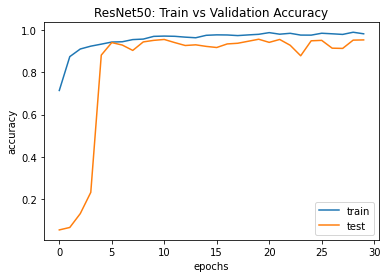

In [9]:
pyplot.title("ResNet50: Train vs Validation Accuracy")
pyplot.plot(model_1_hist.history['accuracy'], label='train')
pyplot.plot(model_1_hist.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')
pyplot.legend()
pyplot.show()

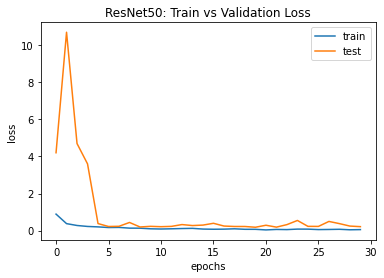

In [10]:
pyplot.title("ResNet50: Train vs Validation Loss")
pyplot.plot(model_1_hist.history['loss'], label='train')
pyplot.plot(model_1_hist.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

In [11]:
# inception resnet
model_2_name="inception"
model_2=create_compile_inception_resnet_v2(model_2_name)
model_2_hist, model_2_best_weights_file=train(model_2, EPOCHS)

Epoch 1/30
238/238 [==============================] - 147s 561ms/step - loss: 0.8818 - accuracy: 0.7281 - val_loss: 0.6192 - val_accuracy: 0.8617
Epoch 2/30
238/238 [==============================] - 128s 536ms/step - loss: 0.2826 - accuracy: 0.9103 - val_loss: 0.9297 - val_accuracy: 0.8976
Epoch 3/30
238/238 [==============================] - 128s 537ms/step - loss: 0.2053 - accuracy: 0.9343 - val_loss: 0.2722 - val_accuracy: 0.9314
Epoch 4/30
238/238 [==============================] - 128s 538ms/step - loss: 0.1514 - accuracy: 0.9519 - val_loss: 0.8699 - val_accuracy: 0.9261
Epoch 5/30
238/238 [==============================] - 126s 529ms/step - loss: 0.1442 - accuracy: 0.9582 - val_loss: 0.5514 - val_accuracy: 0.9029
Epoch 6/30
238/238 [==============================] - 128s 536ms/step - loss: 0.0948 - accuracy: 0.9692 - val_loss: 0.3327 - val_accuracy: 0.9282
Epoch 7/30
238/238 [==============================] - 129s 543ms/step - loss: 0.1053 - accuracy: 0.9669 - val_loss: 0.3727 -

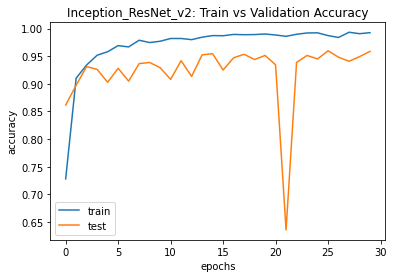

In [12]:
pyplot.title("Inception_ResNet_v2: Train vs Validation Accuracy")
pyplot.plot(model_2_hist.history['accuracy'], label='train')
pyplot.plot(model_2_hist.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')
pyplot.legend()
pyplot.show()

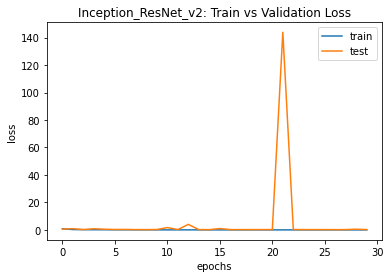

In [13]:
pyplot.title("Inception_ResNet_v2: Train vs Validation Loss")
pyplot.plot(model_2_hist.history['loss'], label='train')
pyplot.plot(model_2_hist.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

In [14]:
model_3_name="resnet101"
model_3=create_compile_resnet101_v2(model_3_name)
model_3_hist, model_3_best_weights_file=train(model_3, EPOCHS)

Epoch 1/30
238/238 [==============================] - 131s 520ms/step - loss: 1.0735 - accuracy: 0.6597 - val_loss: 0.5812 - val_accuracy: 0.8184
Epoch 2/30
238/238 [==============================] - 123s 519ms/step - loss: 0.4144 - accuracy: 0.8677 - val_loss: 0.3700 - val_accuracy: 0.8817
Epoch 3/30
238/238 [==============================] - 127s 534ms/step - loss: 0.3262 - accuracy: 0.8940 - val_loss: 0.3106 - val_accuracy: 0.8955
Epoch 4/30
238/238 [==============================] - 125s 523ms/step - loss: 0.2691 - accuracy: 0.9067 - val_loss: 0.3495 - val_accuracy: 0.8881
Epoch 5/30
238/238 [==============================] - 122s 513ms/step - loss: 0.2436 - accuracy: 0.9153 - val_loss: 0.2990 - val_accuracy: 0.9187
Epoch 6/30
238/238 [==============================] - 125s 524ms/step - loss: 0.2023 - accuracy: 0.9287 - val_loss: 0.2889 - val_accuracy: 0.9134
Epoch 7/30
238/238 [==============================] - 123s 516ms/step - loss: 0.1721 - accuracy: 0.9395 - val_loss: 0.2401 -

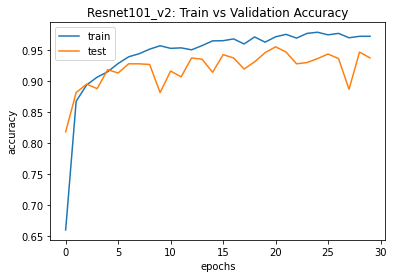

In [15]:
pyplot.title("Resnet101_v2: Train vs Validation Accuracy")
pyplot.plot(model_3_hist.history['accuracy'], label='train')
pyplot.plot(model_3_hist.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')
pyplot.legend()
pyplot.show()

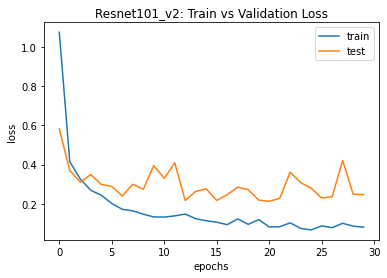

In [16]:
pyplot.title("Resnet101_v2: Train vs Validation Loss")
pyplot.plot(model_3_hist.history['loss'], label='train')
pyplot.plot(model_3_hist.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

In [17]:
model_1_best_weights_file="weights/resnet.hdf5"
model_2_best_weights_file="weights/inception.hdf5"
model_3_best_weights_file="weights/resnet101.hdf5"
ensemble_model_1=create_compile_resnet50()
ensemble_model_2=create_compile_inception_resnet_v2()
ensemble_model_3=create_compile_resnet101_v2()
ensemble_model_1.load_weights(model_1_best_weights_file)
ensemble_model_2.load_weights(model_2_best_weights_file)
ensemble_model_3.load_weights(model_3_best_weights_file)
models=[ensemble_model_1, ensemble_model_2, ensemble_model_3]

In [18]:
def ensemble(models, model_input):
    yModels=[model(model_input) for model in models]
    yAvg=Average()(yModels)
    
    model=Model(model_input, yAvg, name='ensemble')
    
    return model

In [19]:
model_input=Input(IMG_SHAPE)
ensemble_model=ensemble(models, model_input)
# error=evaluate_error(ensemble_model)

In [20]:
preds = ensemble_model.predict(test_generator, steps=test_generator.samples, verbose=1)

794/794 [==============================] - 46s 52ms/step


In [21]:
class_list = []
species_list = [
    "Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"
]
for i in range(preds.shape[0]):
    y_class = preds[i,:].argmax(axis=-1)
    class_list.append(species_list[y_class])
    
submission = pd.DataFrame()
file_names = [f for f in glob.glob("./plant-seedlings-classification/test/*.png")]
submission['file'] = file_names
submission['file'] = submission['file'].apply(lambda x: x.replace("./plant-seedlings-classification/test\\", ''))
submission['species'] = class_list

submission.to_csv('submission.csv', index=False)

In [22]:
# call kaggle to make late submission